In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save simulation results
import dill
import pickle

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# AR1 model using python
#from models.AR1 import ar1_predict, ar1_f, ar1_jac

# data assimilation routines
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import _EKF, _EKS, EKS, EM_EKS
from algos.LI_EKS import LI_EKF, LI_EKS
from algos.CI_EKS import CI_EKF, CI_EKS
from algos.BI_EKF import BI_EKF
from algos.utils import climat_background, RMSE, gen_truth, gen_obs, cov_prob

Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


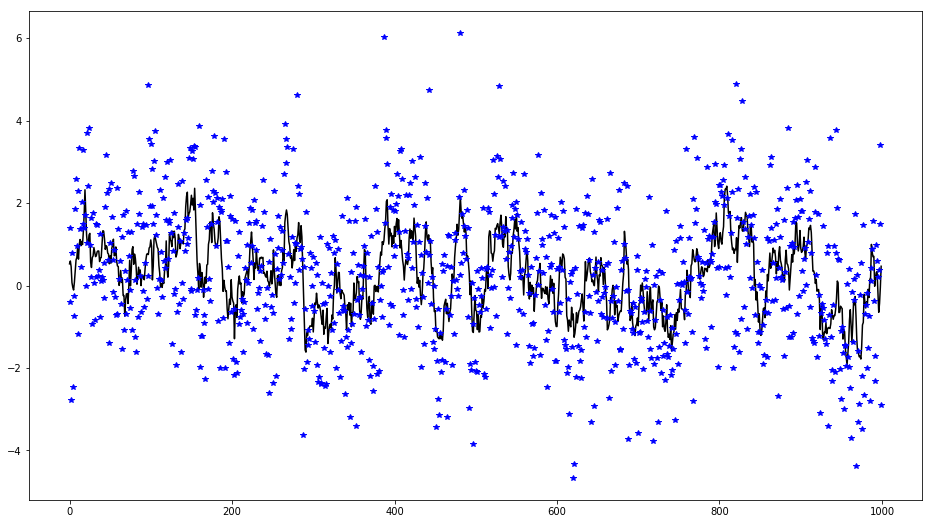

In [2]:
# random number generator
prng = numpy.random.RandomState(1)

# dynamical model
Nx = 1
f = lambda x: 0.95*x
jacF = lambda x: array([0.95])

# observation operator
No = 1
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = eye(Nx)

# size of the sequence
T = 100000

# generate state
Q_true = eye(Nx) * .1
X0_true = array(zeros(Nx))
X_true = gen_truth(f, X0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 1
R_true = eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

# plot state and observations
plot(X_true[:,:1000].T,'k-')
plot(Yo[:,:1000].T, '*b')

In [3]:
# background state
xb, B_tmp = climat_background(X_true)
B = eye(Nx)*B_tmp

# parameters
params = { 'observations'                 : Yo,
           'background_state'             : xb,
           'background_covariance'        : B,
           'model_noise_covariance'       : Q_true,
           'observation_noise_covariance' : R_true,
           'model_dynamics'               : f,
           'model_jacobian'               : jacF,
           'observation_operator'         : h,
           'observation_jacobian'         : jacH,
           'state_size'                   : Nx,
           'observation_size'             : No,
           'temporal_window_size'         : T,
           'true_state'                   : X_true,
           'inflation_factor'             : 1
          }

# function
res_EKS = EKS(params)

# extract outputs
loglik_true = res_EKS['loglikelihood']
RMSE_true = res_EKS['RMSE']
cov_prob_true = res_EKS['cov_prob']

In [ ]:
# initial counditions and number of iterations
N_iter = 100
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full', # Q and R are full
           #'model_noise_covariance_matrix_template'   : eye(Nx,Nx), # Q is constant diagonal
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True, ### IMPORTANT
           'inflation_factor'                         : 1}

# function
res_EM_EKS = EM_EKS(params)

# store simulation results
dill.dump(res_EM_EKS, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_EKS_AR1.pkl', 'wb'))

In [ ]:
# initial counditions and number of iterations
N_iter = 100
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# loop on tau parameter for temporal smoothing
tab_tau = [100000, 500000, 1000000]
for tau in tab_tau:

    # parameters
    params = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : f,
               'model_jacobian'                           : jacF,
               'observation_operator'                     : h,
               'observation_jacobian'                     : jacH,
               'observations'                             : Yo,
               'nb_iterations'                            : N_iter,
               'true_state'                               : X_true,
               'state_size'                               : Nx,
               'observation_size'                         : No,
               'temporal_window_size'                     : T,
               'model_noise_covariance_structure'         : 'full', # Q and R are full
               'inflation_factor'                         : 1,
               'adaptive_parameter'                       : tau ### IMPORTANT
             }

    # function
    res_LI_EKS = LI_EKS(params)
    
    # store simulation results
    filename = 'res_LI_EKS_AR1_' + str(tau) + '.pkl'
    dill.dump(res_LI_EKS, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'wb'))

/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


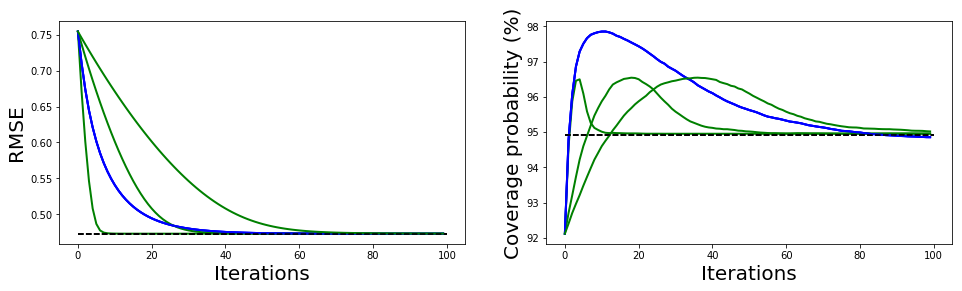

In [8]:
##########################################################
# load simulation results
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_EKS_AR1.pkl', 'rb') as in_strm:
    res_EM_EKS = dill.load(in_strm)

# extract outputs(EM-EKS)
Q_EM_EKS = res_EM_EKS['EM_model_noise_covariance']
R_EM_EKS = res_EM_EKS['EM_observation_noise_covariance']
loglik_EM_EKS=res_EM_EKS['loglikelihood']
RMSE_EM_EKS=res_EM_EKS['RMSE']
cov_prob_EM_EKS=res_EM_EKS['cov_prob']
##########################################################
    
# loop on tau parameter for temporal smoothing (LI_EKS)
N_iter = 100
tab_tau = [100000, 500000, 1000000]
for tau in tab_tau:

    ##########################################################
    # load simulation results
    filename = 'res_LI_EKS_AR1_' + str(tau) + '.pkl'
    with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
        res_LI_EKS = dill.load(in_strm)

    # extract outputs (LI-EKS)
    Q_LI_EKS = res_LI_EKS['LI_model_noise_covariance']
    R_LI_EKS = res_LI_EKS['LI_observation_noise_covariance']
    loglik_LI_EKS = res_LI_EKS['loglikelihood']
    RMSE_LI_EKS = res_LI_EKS['RMSE']    
    cov_prob_LI_EKS=res_LI_EKS['cov_prob']
    ##########################################################

    # plot trace of Q
    plt.subplot(2,2,1)
    line1,=plt.plot(trace(Q_EM_EKS)/Nx,'b', linewidth=2)
    line2,=plt.plot(trace(Q_LI_EKS)/Nx,'g', linewidth=2)
    line3,=plt.plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('Q estimates', fontsize=20)
    ylim([0,1])
    plt.legend([line1, line2, line3], ['Offline EM', 'Offline LI', 'Truth'], fontsize=20)
    plt.text(10, 0.01+trace(Q_LI_EKS[:,:,10])/Nx, r'$\tau =$' + str(tau), color='green')
    
    # plot trace of R
    plt.subplot(2,2,2)
    line1,=plt.plot(trace(R_EM_EKS)/No,'b', linewidth=2)
    line2,=plt.plot(trace(R_LI_EKS)/No,'g', linewidth=2)
    line3,=plt.plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('R estimates', fontsize=20)
    ylim([1,2.2])
    
# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/AR1_Q_R_offline_1.png', bbox_inches='tight')

close()

for tau in tab_tau:

    ##########################################################
    # load simulation results
    filename = 'res_LI_EKS_AR1_' + str(tau) + '.pkl'
    with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
        res_LI_EKS = dill.load(in_strm)

    # extract outputs (LI-EKS)
    Q_LI_EKS = res_LI_EKS['LI_model_noise_covariance']
    R_LI_EKS = res_LI_EKS['LI_observation_noise_covariance']
    loglik_LI_EKS = res_LI_EKS['loglikelihood']
    RMSE_LI_EKS = res_LI_EKS['RMSE']    
    cov_prob_LI_EKS=res_LI_EKS['cov_prob']
    ##########################################################

    # plot Root Mean Square Error
    plt.subplot(2,2,3)
    line1,=plt.plot(RMSE_EM_EKS,'b', linewidth=2)
    line2,=plt.plot(RMSE_LI_EKS,'g', linewidth=2)
    line3,=plt.plot((0,N_iter),(RMSE_true,RMSE_true),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('RMSE', fontsize=20)

    # plot coverage probability
    plt.subplot(2,2,4)
    line1,=plt.plot(cov_prob_EM_EKS*100,'b', linewidth=2)
    line2,=plt.plot(cov_prob_LI_EKS*100,'g', linewidth=2)
    line3,=plt.plot((0,N_iter),(cov_prob_true*100,cov_prob_true*100),'--k')
    #plt.ylim([90,100])
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('Coverage probability (%)', fontsize=20)
    
# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/AR1_Q_R_offline_2.png', bbox_inches='tight')